# Matrix-based scaling experiment
> More scaling, this time with the matrix-based generator and solver

Updated Nov 29, 2022

In [1]:
import sys
sys.path.append('/home/phil/aptr')
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.simulation_new import make_tables
from src.database import RnaDB
from src.torch_solver import TorchSolver

In [3]:
rnadb = RnaDB(
    path_to_dnaA = "../../data/allDnaA.tsv",
    path_to_16s = "../../data/allSSU.tsv",
)

0.9992494370778083 sequences remain after trimming
0.6346009507130348 sequences remain after filtering


In [4]:
# This takes about 5 minutes for 100 samples
abundances, log2_ptrs, otus = make_tables(
    n_genomes=10,
    n_samples=20,
    db=rnadb,
    sparsity=0,
    multiplier=1
)

In [5]:
solver = TorchSolver(otus=otus, db=rnadb)

Using OTU index for md5s


In [6]:
def score(solver, true_abundances, true_log2_ptrs):
    inferred_ptrs = pd.DataFrame(
        data=solver.B_hat.exp2().detach().numpy(),
        index=solver.genome_ids,
        columns=solver.sample_ids,
    )
    inferred_abundances = pd.DataFrame(
        data=solver.A_hat.detach().numpy(),
        index=solver.genome_ids,
        columns=solver.sample_ids,
    )
    true_ptrs = np.exp2(true_log2_ptrs).reindex(inferred_ptrs.index)
    true_abundances = true_abundances.reindex(inferred_abundances.index)

    ptr_score = true_ptrs - inferred_ptrs
    abundance_score = true_abundances - inferred_abundances
    return ptr_score, abundance_score, inferred_ptrs, inferred_abundances


# Effect of number of genomes

In [7]:
results = pd.DataFrame()
for n_genomes in range(1, 20):
    print(n_genomes)
    abundances, log2_ptrs, otus = make_tables(
        n_genomes=n_genomes,
        n_samples=20 - n_genomes,  # same number of samples for each
        db=rnadb,
        sparsity=0,
        multiplier=1,
    )
    solver = TorchSolver(otus=otus, db=rnadb)
    solver.train(lr=0.1, clip=True, model_bias=False)
    B_scores, A_scores, B_inf, A_inf = score(
        solver=solver,
        true_log2_ptrs=log2_ptrs,
        true_abundances=abundances,
    )
    for i, genome_id in enumerate(solver.genome_ids):
        for j, sample_id in enumerate(solver.sample_ids):
            try:
                results = results.append(
                    {
                        "n_genomes": n_genomes,
                        "genome": genome_id,
                        "sample": sample_id,
                        "true_ptr": np.exp2(log2_ptrs.loc[genome_id, sample_id]),
                        "inferred_ptr": B_inf.loc[genome_id, sample_id],
                        "inferred_abundance": A_inf.loc[genome_id, sample_id],
                        "abundance": abundances.loc[genome_id, sample_id],
                        "ptr_score": B_scores.loc[genome_id, sample_id],
                        "abundance_score": A_scores.loc[genome_id, sample_id],
                        "n_reads": otus.loc[
                            rnadb[genome_id]["md5"].unique(), sample_id
                        ].sum(),
                    },
                    ignore_index=True,
                )
            except KeyError as e:
                print(f"=====KEY ERROR: {e}")

results


1
Using OTU index for md5s
Initial:	 -284.1429138183594
Epoch 0:	 -3608.630859375
Epoch 1:	 -4043.529296875
Epoch 2:	 -4311.77001953125
Epoch 3:	 -4511.046875
Epoch 4:	 -4670.48046875
Epoch 5:	 -4801.83642578125
Epoch 6:	 -4910.87109375
Epoch 7:	 -5001.111328125
Epoch 8:	 -5075.3447265625
Epoch 9:	 -5136.1142578125
Epoch 10:	 -5185.654296875
Epoch 11:	 -5225.98974609375
Epoch 12:	 -5258.70458984375
Epoch 13:	 -5285.052734375
Epoch 14:	 -5306.0439453125
Epoch 15:	 -5322.50390625
Epoch 16:	 -5335.1748046875
Epoch 17:	 -5344.73291015625
Epoch 18:	 -5351.79833984375
Epoch 19:	 -5356.9208984375
Epoch 20:	 -5360.58154296875
Epoch 21:	 -5363.14990234375
Epoch 22:	 -5364.82080078125
Epoch 23:	 -5365.79541015625
Epoch 24:	 -5366.29296875
Epoch 25:	 -5366.5244140625
Epoch 26:	 -5366.62744140625
Epoch 27:	 -5366.71484375
Epoch 28:	 -5366.783203125
Epoch 29:	 -5366.8291015625
Epoch 30:	 -5366.85498046875
Epoch 31:	 -5366.865234375
Epoch 32:	 -5366.86767578125
Epoch 33:	 -5366.86572265625
Epoch 34:

,abundance,abundance_score,genome,inferred_abundance,inferred_ptr,n_genomes,n_reads,ptr_score,sample,true_ptr
0,6.264821,-1852.932567,335543.9,1859.197388,1.300011,1.0,6473.0,0.020524,0.0,1.320535
1,0.160709,-47.464619,335543.9,47.625328,2.000000,1.0,133.0,-0.003365,1.0,1.996635
2,0.729500,-186.270500,335543.9,187.000000,1.000000,1.0,748.0,0.316713,2.0,1.316713
3,1.007744,-274.539741,335543.9,275.547485,1.044040,1.0,1077.0,0.110955,3.0,1.154995
4,0.366529,-106.556567,335543.9,106.923096,1.370297,1.0,362.0,0.214717,4.0,1.585014
...,...,...,...,...,...,...,...,...,...,...
1325,0.311657,-109.704052,2094.20,110.015709,1.377816,19.0,330.0,-0.253961,0.0,1.123854
1326,0.665776,-200.677959,324057.4,201.343735,1.190750,19.0,4589.0,0.011568,0.0,1.202318
1327,1.322698,-392.341303,698737.3,393.664001,1.637863,19.0,3834.0,-0.059197,0.0,1.578666
1328,0.881286,-253.299881,1294143.3,254.181168,1.377040,19.0,2203.0,0.011960,0.0,1.388999


Text(0.5, 0, '')

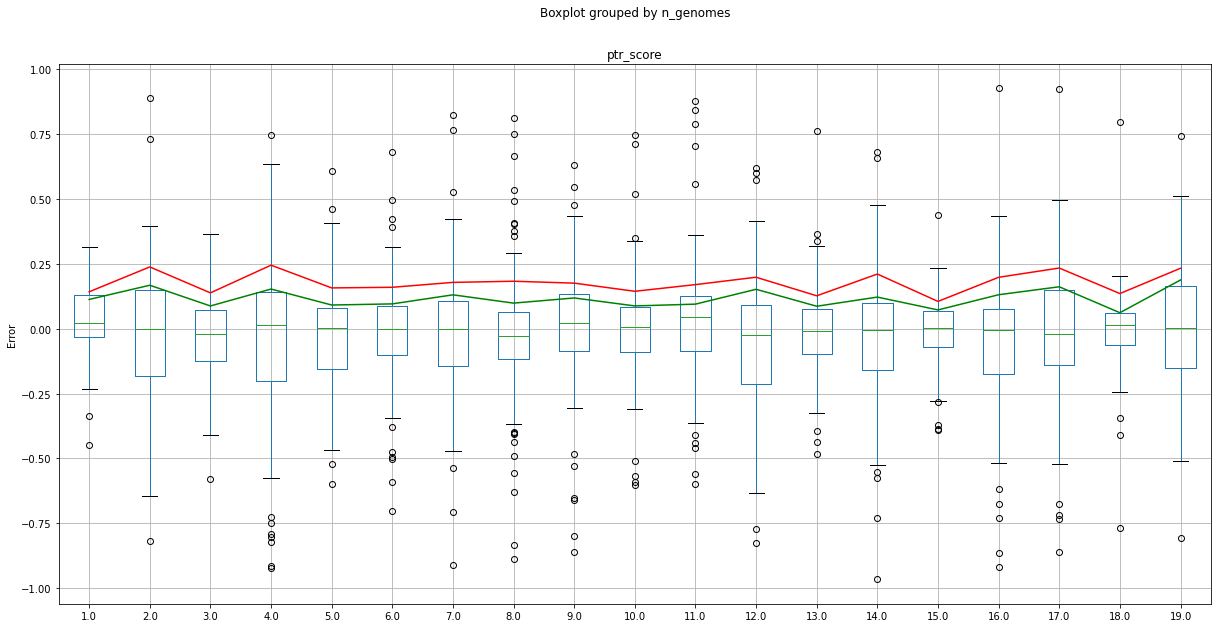

In [8]:
results.boxplot(by="n_genomes", column="ptr_score", figsize=(20, 10))

# Draw error on same figure with different y axis
plt.plot(np.arange(1, 20), results[["n_genomes", "ptr_score"]].abs().groupby("n_genomes").mean()["ptr_score"], c="red")
plt.plot(np.arange(1, 20), results[["n_genomes", "ptr_score"]].abs().groupby("n_genomes").median()["ptr_score"], c="green")
plt.ylabel("Error")
plt.xlabel("")

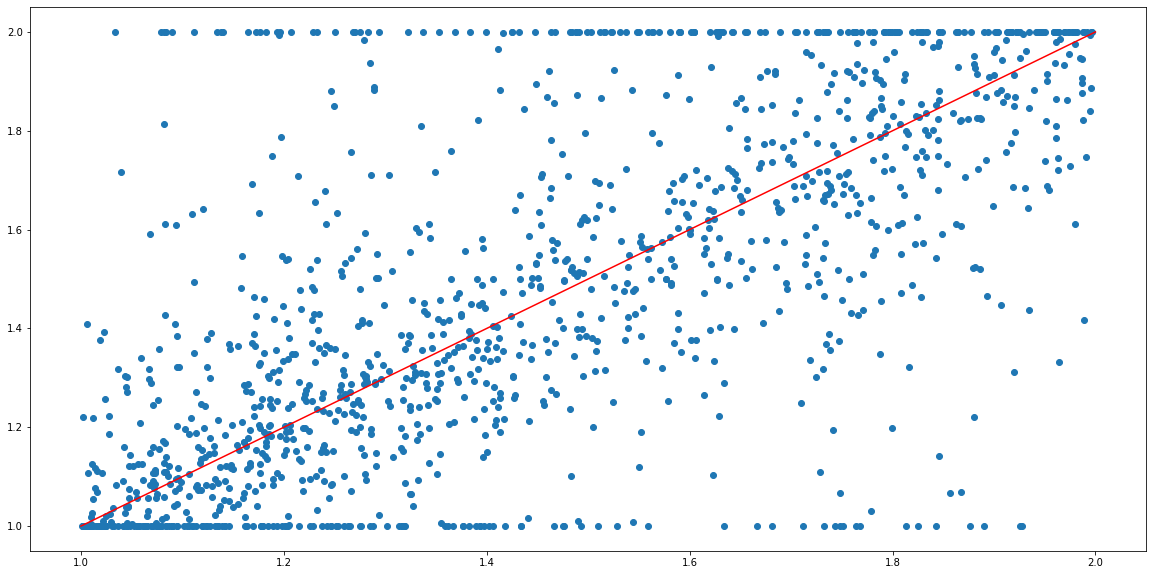

In [9]:
fig = plt.figure(figsize=(20, 10))
plt.scatter(results["true_ptr"], results["inferred_ptr"])
plt.plot([1,2], [1,2], c="red")

(array([851., 253., 103.,  49.,  24.,  15.,  11.,   9.,   4.,   2.,   3.,
          3.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([4.70000e+01, 3.42710e+03, 6.80720e+03, 1.01873e+04, 1.35674e+04,
        1.69475e+04, 2.03276e+04, 2.37077e+04, 2.70878e+04, 3.04679e+04,
        3.38480e+04, 3.72281e+04, 4.06082e+04, 4.39883e+04, 4.73684e+04,
        5.07485e+04, 5.41286e+04, 5.75087e+04, 6.08888e+04, 6.42689e+04,
        6.76490e+04]),
 <BarContainer object of 20 artists>)

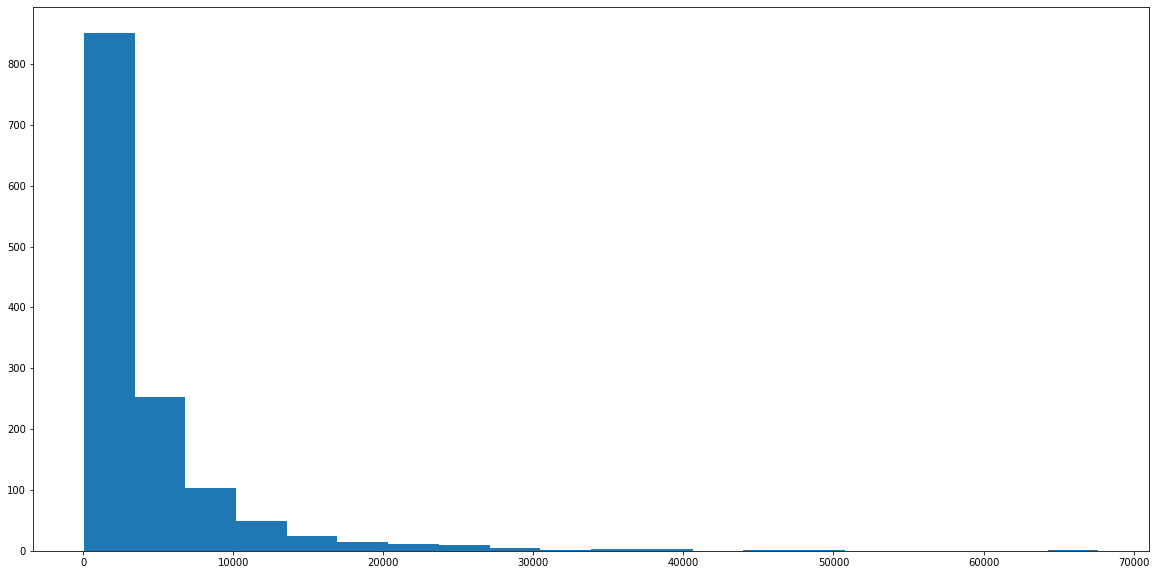

In [10]:
fig = plt.figure(figsize=(20, 10))
plt.hist(results["n_reads"], bins=20)

# Effect of scaling factor

In [16]:
results_scaling = pd.DataFrame()
for scaling_factor in range(-5, 2):
    print(scaling_factor)
    abundances, log2_ptrs, otus = make_tables(
        n_genomes=5,
        n_samples=20,  # same number of samples for each
        db=rnadb,
        sparsity=0,
        multiplier=10**scaling_factor,
    )
    solver = TorchSolver(otus=otus, db=rnadb)
    try:
        solver.train(lr=0.1, clip=True)
    except Exception as e:
        print(e)
        continue
    B_scores, A_scores, B_inf, A_inf = score(
        solver=solver,
        true_log2_ptrs=log2_ptrs,
        true_abundances=abundances,
    )
    for i, genome_id in enumerate(solver.genome_ids):
        for j, sample_id in enumerate(solver.sample_ids):
            try:
                results_scaling = results_scaling.append(
                    {
                        "scaling": scaling_factor,
                        "genome": genome_id,
                        "sample": sample_id,
                        "true_ptr": np.exp2(log2_ptrs.loc[genome_id, sample_id]),
                        "inferred_ptr": B_inf.loc[genome_id, sample_id],
                        "inferred_abundance": A_inf.loc[genome_id, sample_id],
                        "abundance": abundances.loc[genome_id, sample_id],
                        "ptr_score": B_scores.loc[genome_id, sample_id],
                        "abundance_score": A_scores.loc[genome_id, sample_id],
                        "n_reads": otus.loc[
                            rnadb[genome_id]["md5"].unique(), sample_id
                        ].sum(),
                    },
                    ignore_index=True,
                )
            except Exception as e:
                print(e)

results_scaling


-5
Using OTU index for md5s
Initial:	 1.8448117971420288
Epoch 0:	 0.09375
Epoch 1:	 0.09375
Epoch 2:	 0.09375
Epoch 3:	 0.09375
Epoch 4:	 0.09375
Epoch 5:	 0.09375
Epoch 6:	 0.09375
-4
Using OTU index for md5s
Initial:	 1.8052712678909302
Epoch 0:	 0.24158892035484314
Epoch 1:	 0.24158889055252075
Epoch 2:	 0.24158889055252075
Epoch 3:	 0.24158892035484314
Epoch 4:	 0.24158892035484314
Epoch 5:	 0.24158889055252075
Epoch 6:	 0.2416774183511734
Epoch 7:	 0.24158896505832672
'273119.6'
'273119.6'
'273119.6'
'273119.6'
'273119.6'
'273119.6'
'273119.6'
'273119.6'
'273119.6'
'273119.6'
'273119.6'
'273119.6'
'273119.6'
'273119.6'
-3
Using OTU index for md5s
Initial:	 1.1828824281692505
Epoch 0:	 0.30947762727737427
Epoch 1:	 0.30947765707969666
Epoch 2:	 0.3095073401927948
Epoch 3:	 0.3094785213470459
Epoch 4:	 0.30948054790496826
Epoch 5:	 0.30981606245040894
Epoch 6:	 0.30948227643966675
-2
Using OTU index for md5s
Initial:	 -3.97149395942688
Epoch 0:	 -16.894704818725586
Epoch 1:	 -16.91

,abundance,abundance_score,genome,inferred_abundance,inferred_ptr,n_reads,ptr_score,sample,scaling,true_ptr
0,5.712292,5.712292,1144275.3,0.000000,2.000000,0.0,-0.594868,15.0,-5.0,1.405132
1,1.932036,1.932036,1144275.3,0.000000,2.000000,0.0,-0.299586,18.0,-5.0,1.700414
2,0.573186,0.573186,525897.5,0.000000,2.000000,0.0,-0.365955,15.0,-5.0,1.634045
3,0.673724,0.673724,525897.5,0.000000,2.000000,0.0,-0.694431,18.0,-5.0,1.305569
4,1.183970,1.183970,688270.3,0.000000,2.000000,0.0,-0.800029,15.0,-5.0,1.199971
...,...,...,...,...,...,...,...,...,...,...
575,0.207695,-615.944832,486410.3,616.152527,1.181788,5900.0,0.088517,15.0,1.0,1.270305
576,1.859529,-5610.181486,486410.3,5612.041016,1.965808,48057.0,-0.044116,16.0,1.0,1.921692
577,1.043207,-3136.560064,486410.3,3137.603271,1.701713,27713.0,-0.049560,17.0,1.0,1.652153
578,3.341954,-10123.618983,486410.3,10126.960938,1.479237,92227.0,-0.071229,18.0,1.0,1.408009


<AxesSubplot:title={'center':'ptr_score'}, xlabel='scaling'>

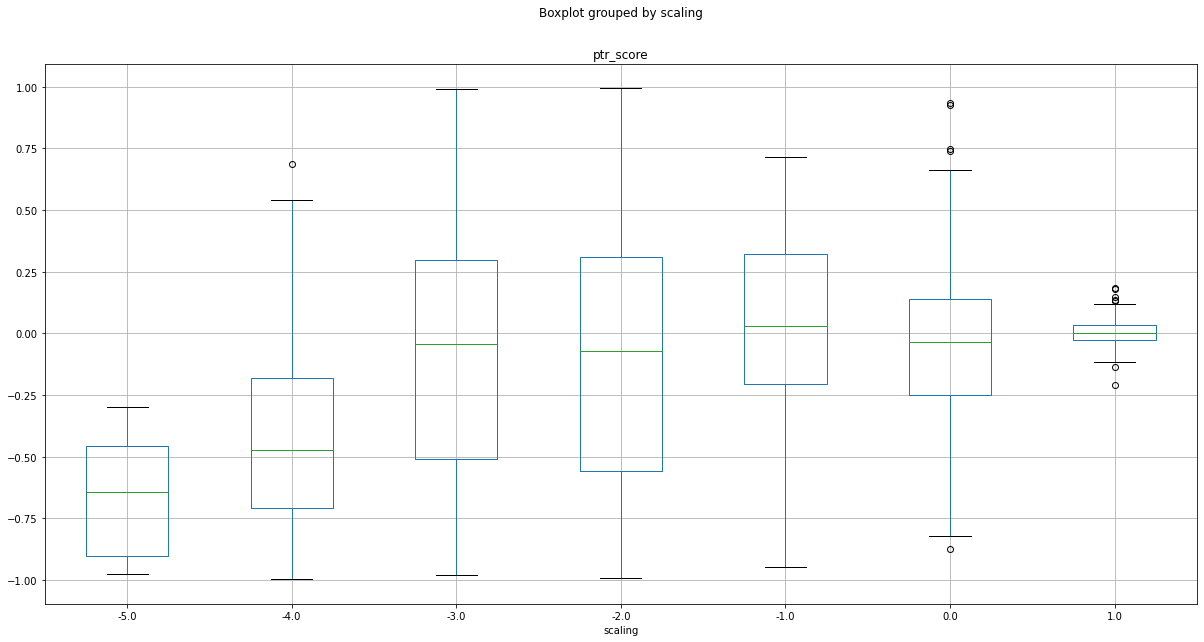

In [17]:
results_scaling.boxplot(by="scaling" column="ptr_score", figsize=(20, 10))

Text(0, 0.5, 'Error')

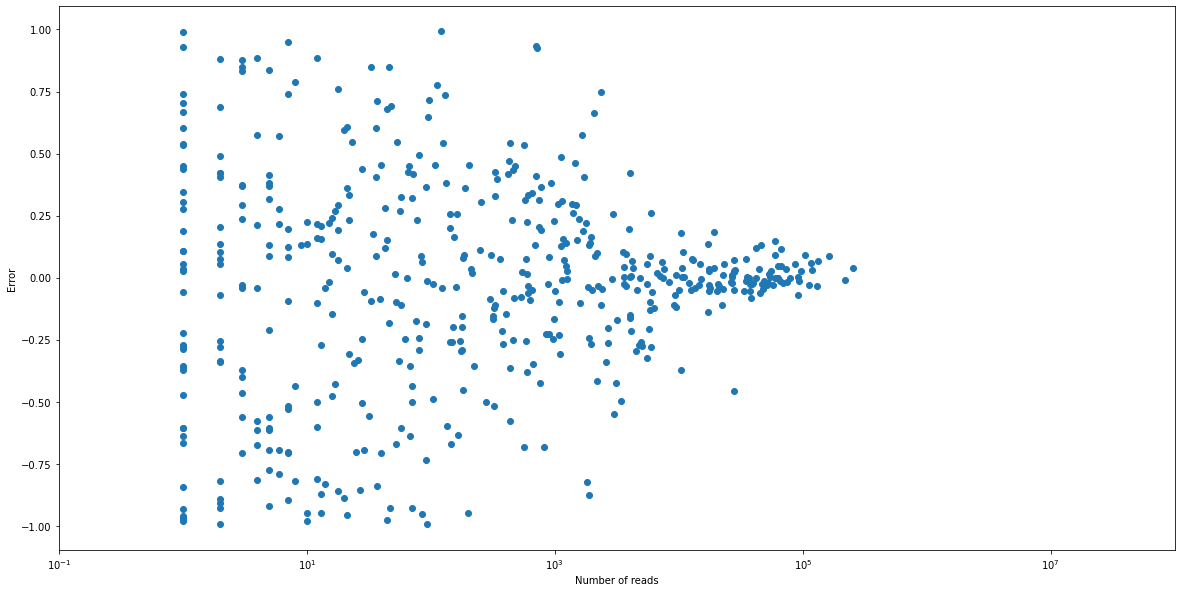

In [18]:
figure = plt.figure(figsize=(20, 10))

plt.scatter(results_scaling["n_reads"], results_scaling["ptr_score"])
plt.xscale("log")
plt.xlim([.1, 1e8])
plt.xlabel("Number of reads")
plt.ylabel("Error")